In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.models import load_model
import cv2

import matplotlib as mpl
import subprocess
import skimage
import skimage.io as imio
import skimage.transform as trans
import glob
import re
from time import gmtime, strftime, sleep
from PIL import Image
from scipy import signal,misc
mpl.rcParams['figure.figsize'] = (8.0, 4.0) 

from quad_solver import solver

In [2]:
saliency = load_model('HED4.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [3]:
def initialFocus(sid=2):
    #10.42.0.90: local 10.236.176.152: ip
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=2, pos=512):
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=2, pos=512):
    cmD='rsh nvidia@10.236.176.152 "sudo ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grabImage(sid=2, imres=8, cameraIP='10.236.176.152'):
    # I will use the file name qhGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images
    cmdA='ssh nvidia@'+cameraIP
    cmdB='scp nvidia@'+cameraIP
    subprocess.run('rm qhGrab*', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm *raw', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm qhGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdA+' "rm *.raw"', \
                   stdout=subprocess.PIPE, shell=True)
    # ok, now let's grab an image on the tegra
    cmD=cmdA+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 --dump-bayer\
 --file-name qhGrab --image-res '+ str(imres)+'"'
    subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    tCmd=cmdB+':qhGrab* .'
    subprocess.run(cmdB+':qhGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run(cmdB+':*.raw .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'qhGrab(.*).jpg', rePop)
    fileName=fileName.group()
    jIm=imio.imread(fileName)
    fileName = re.search(r'nvcamtest_bayer(.*).raw', rePop)
    fileName=fileName.group()

    rIm=np.fromfile(fileName,dtype=np.dtype('i2'))
    # Note the array dtype above of >i2. The > means ‘big-endian’ (< is little-endian)
    # and i2 means ‘signed 2-byte integer’. For example, if our data represented a 
    # single unsigned 4-byte little-endian integer, the dtype string would be < u4 .
    rows=2160
    runL=3840
    rIm=np.reshape(rIm[:rows*runL],(rows,runL))
    return jIm, rIm

In [4]:
# def patchExtraction(sid = 2):
#     jIm, rIm = grabImage(sid = sid)
#     I = rIm
#     m, n= I.shape

#     patch = I[m//2-256:m//2+256, n//2-256:n//2+256]
#     patch = (patch - patch.min()) / (patch.max() - patch.min())
#     plt.imshow(jIm)
#     plt.imshow(rIm)
#     plt.show()
#     return patch


In [12]:
def patchExtraction(sid = 2):
    jIm,rIm = grabImage(sid = sid)
    jIm = jIm[::-1, ::-1, :]
    plt.imshow(jIm)
    plt.show()
    m, n= rIm.shape
    im = rIm/(2**14-1)
    img=Image.fromarray(np.uint8(im*255))
    img = img.resize((400,300))
    inpt = np.array(img)/255
    res = saliency.predict(inpt.reshape(1,300,400,1))
    res = res.reshape(300,400)
    w=np.ones((71,53))
    res_new=signal.convolve2d(res,w,mode='same')
    pos = np.where(res_new==np.max(res_new))
    x = np.round(pos[0]*(m/300))
    y = np.round(pos[1]*(n/400))
    patch = rIm[int(x)-256:int(x)+256, int(y)-256:int(y)+256]
    plt.imshow(res)
    plt.show()
    plt.imshow(jIm[int(x)-256:int(x)+256, int(y)-256:int(y)+256])
    plt.show()
    patch = (patch - patch.min()) / (patch.max() - patch.min())
    return patch

In [6]:
initialFocus(sid=2)

b'sensor-id:2\nDemo Initialize\nDemo Start\nOIS Initilize\nEEPROM Read:\n  00 33 00 35 01 F5 02 01 FE 32 FE 86 00 1A 00 1B \n  08 1E 08 09 00 74 19 00 16 4E 29 24 D6 DC 20 00 \n  20 00 00 00 00 00 00 00 01 D8 10 00 00 01 00 01 \n  Gyro gain:6400(x1.00), 5710(x1.00)\nset: [Init:OIS] slave=1a, address=30ac, RegData = 01\n[Init:i2cdat_gyro]\nset: [Init:Start download] slave=3e, address=f010, RegData = 00\n[Init:DownloadProgram1]................................\n[Init:DownloadProgram2]....\n[Init:Calibration]\nset: [Init:Set OIS complete DL] slave=3e, address=f006, RegData = 00\nset: [Init:Servo on] slave=3e, address=6020, RegData = 01\nset: [Init:Gyro on] slave=3e, address=6023, RegData = 02\nset: [Init:Gyro on] slave=3e, address=602c, RegData = 1b\nset: [Init:Gyro on] slave=3e, address=602d, RegData = 10\nset: [Init:Gyro on] slave=3e, address=6023, RegData = 00\n[Init:GPO]\n[Init:PWM frequency]\nset: [OIS Hall current X] slave=3e, address=60a2, RegData = 37\nset: [OIS Hall current Y] sla

In [7]:
discriminator = load_model('raw_models/dis/weights-016-0.932.h5')
#discriminator = load_model('net_para/my_model_dis_512.h5')
model = load_model('raw_models/gen/n_152-0.902.hdf5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [20]:
curr = 500
setFocus(sid=2, pos=curr)

b'sensor-id:2\nDemo Initialize\nDemo Start\nFocus Position:500\n'

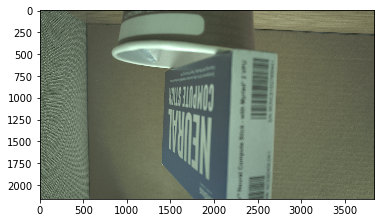

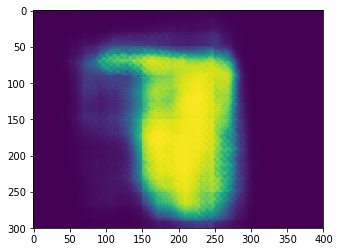

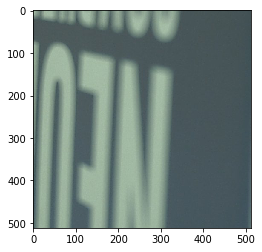

1.0


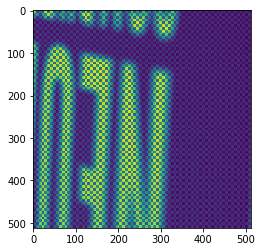

In [23]:
patch = patchExtraction(sid =2)
print(patch.max())
plt.imshow(patch)

In [10]:
pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
print(pred)

[0.99027747 0.00972252]


In [66]:
# # # from tensorflow.python.keras import backend as K

# # # inp = model.input                                           # input placeholder
# # # outputs = [layer.output for layer in model.layers]          # all layer outputs
# # # functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

# # # # Testing
# # # layer_outs = [func([patch[np.newaxis,:,:, np.newaxis], 1.]) for func in functors]
# # # print(layer_outs)
# # get_all_layer_outputs = Kpatch = patchExtraction(sid = 1)
# print(patch.max())
# plt.imshow(patch).function([discriminator.layers[0].input],
# #                                   [l.output for l in discriminator.layers[1:]])

# # layer_output = get_all_layer_outputs([patch[np.newaxis,:,:, np.newaxis]])
# # print(layer_output[4])

New Round -----------Current pos:  1000
6.2350125
curr0:  nan curr1:  596.4352612050242
branch3
curr:  596.4352612050242


/home/qian/Documents/autofocus/quad_solver.py:11: RuntimeWarning: invalid value encountered in sqrt
  sol1 = (-b + np.sqrt(d1))/(2*a2)
/home/qian/Documents/autofocus/quad_solver.py:13: RuntimeWarning: invalid value encountered in sqrt
  sol3 = (-b - np.sqrt(d1))/(2*a2)


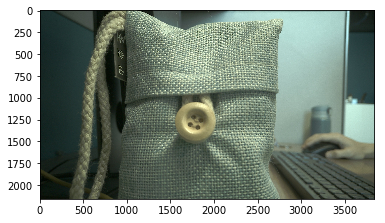

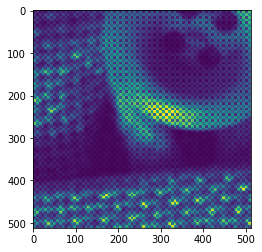

[0.9750099  0.02499005]
New Round -----------Current pos:  596.4352612050242
1.3800844
curr0:  658.897012363606 curr1:  539.9044649467317
branch4


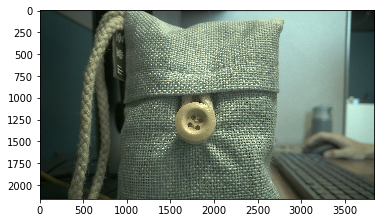

step0:  0.8522498


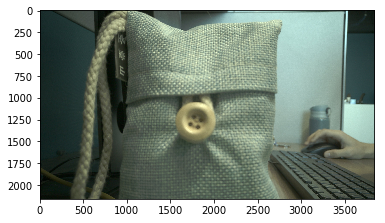

step1:  2.5599513
curr:  658.897012363606
[0.3103155 0.6896845]
Current pos:  658.897012363606


In [11]:
while (pred[0] > pred[1]):  
    print("New Round -----------Current pos: ", curr)

    step = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
    print(step)
    if step < 0.5:
        break
    
    curr0 = curr + solver(curr, step)[0]
    curr1 = curr + solver(curr, step)[1]
    print("curr0: ", curr0, "curr1: ", curr1)
    if curr0 > 1023 and curr1 < 475:
        print("branch1")
        break
    elif curr0  < 1023 and curr1 < 475:
        print("branch2")
        curr = curr0
        print("curr: ", curr)
        setFocus(sid=2, pos=curr)

        patch = patchExtraction()
        plt.imshow(patch)
        plt.show()

        pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
        print(pred)
    elif (curr0  > 1023 and curr1 > 475) or (np.isnan(curr0)):
        print("branch3")
        curr = curr1
        print("curr: ", curr)
        setFocus(sid=2, pos=curr)

        patch = patchExtraction()
        plt.imshow(patch)
        plt.show()

        pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
        print(pred)
    else:
        print("branch4")
        setFocus(sid=2, pos=curr0)
        patch0 = patchExtraction()
        step0 = model.predict(patch0[np.newaxis,:,:, np.newaxis])[0][0]
        print("step0: ", step0)
        setFocus(sid=2, pos=curr1)
        patch1 = patchExtraction()
        step1 = model.predict(patch1[np.newaxis,:,:, np.newaxis])[0][0]
        print("step1: ", step1)
        if step0 < step1:
            curr = curr0
            patch = patch0
        else:
            curr = curr1
            patch = patch1
        print("curr: ", curr)
            
        pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
        print(pred)
            

# setFocus(1, curr + 100*step)
# patch2 = patchExtraction(sid = 1)
# plt.imshow(patch)
# plt.show()
# temp2 = model.predict(patch2[np.newaxis,:,:, np.newaxis])[0][0]
# print(temp2)


# if temp <= temp2:
#     setFocus(sid=1, pos=curr-step*100)
#     curr = max(curr-step*100, 0)
#     pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
#     print(pred)
# else:
#     curr = min(curr+step*100, 1023)
#     pred = discriminator.predict(patch2[np.newaxis,:,:, np.newaxis])[0]
#     print(pred)

print("Current pos: ", curr)

In [10]:
# print("Current pos: ", curr)
# while (pred[0] > pred[1]):    
#     step = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
#     print(step)

#     setFocus(sid=1, pos=curr-step*100)

#     patch = patchExtraction(sid = 1)
#     plt.imshow(patch)
#     plt.show()

#     temp = model.predict(patch[np.newaxis,:,:, np.newaxis])[0][0]
#     print(temp)


#     setFocus(1, curr + 100*step)
#     patch2 = patchExtraction(sid = 1)
#     plt.imshow(patch)
#     plt.show()
#     temp2 = model.predict(patch2[np.newaxis,:,:, np.newaxis])[0][0]
#     print(temp2)
    
    
#     if temp <= temp2:
#         setFocus(sid=1, pos=curr-step*100)
#         curr = max(curr-step*100, 0)
#         pred = discriminator.predict(patch[np.newaxis,:,:, np.newaxis])[0]
#         print(pred)
#     else:
#         curr = min(curr+step*100, 1023)
#         pred = discriminator.predict(patch2[np.newaxis,:,:, np.newaxis])[0]
#         print(pred)
        
#     print("Current pos: ", curr)